In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras

# generate data
X, y = datasets.make_classification(n_samples=10000, n_features=50, n_redundant=10, n_informative=10,
                           random_state=1, n_clusters_per_class=2,n_classes=3, class_sep=2)
                           
# divide data in Train - Validation - Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_tr, X_valid, y_tr, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42) 

# Standardize Data
sc = StandardScaler()
X_tr_std = sc.fit_transform(X_tr)
X_valid_std = sc.transform(X_valid)
X_test_std = sc.transform(X_test)

2024-04-22 15:32:47.489368: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 15:32:47.489628: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 15:32:47.669429: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


lr parameter is now learning_rate. An easy fix to get this to run!

In [2]:
encoder = keras.models.Sequential([
    keras.layers.Dense(5, input_shape=[50]),
])

decoder = keras.models.Sequential([
    keras.layers.Dense(50, input_shape=[5]),
])

autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer = keras.optimizers.SGD(learning_rate=0.1))

history = autoencoder.fit(X_tr_std,X_tr_std, epochs=100,validation_data=(X_valid_std,X_valid_std),
                         callbacks=[keras.callbacks.EarlyStopping(patience=10)])
                         
codings_train = encoder.predict(X_tr_std)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0613 - val_loss: 0.8003
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7779 - val_loss: 0.7200
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7231 - val_loss: 0.7001
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6991 - val_loss: 0.6913
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6958 - val_loss: 0.6865
Epoch 6/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6923 - val_loss: 0.6838
Epoch 7/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6843 - val_loss: 0.6822
Epoch 8/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6807 - val_loss: 0.6812
Epoch 9/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6837 - val_loss: 0.6801
Epoch 10/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6811 - val_loss: 0.6792
Epoch 11/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6844 - val_loss: 0.6785
Epoch 12/100
175/175 ━━━━━━━━━━━━━━━━━━━━

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5,svd_solver='auto')
scores_train = pca.fit_transform(X_tr_std) # u

Looks like this code requires data from the PCA and AutoEncoder runs.  My guess is that it wants the scores info, named as scores and coding \_train. Right now they are both named just 'scores'.

In [4]:
codings_train

array([[ 2.3542323 , -0.8172579 ,  1.0810466 ,  0.734985  , -0.97388643],
       [-3.9176362 , -1.303263  ,  0.92363566,  3.6022813 ,  0.6068199 ],
       [ 0.73059106, -1.387369  , -0.8978906 ,  0.12282084, -1.8338984 ],
       ...,
       [ 1.6506536 ,  0.8035413 , -2.9585254 , -0.0052999 ,  0.4087533 ],
       [ 0.38761804, -1.1776519 , -0.73107713, -1.5021552 ,  1.3814675 ],
       [-0.97415036, -1.974098  ,  0.37053064, -0.8877274 , -1.3486313 ]],
      dtype=float32)

(0.9, 1.0)

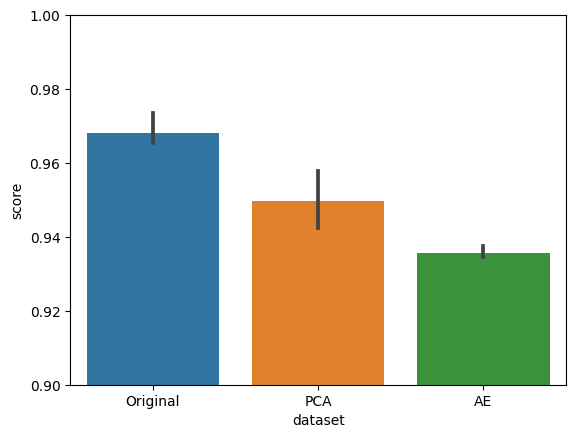

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rfc = RandomForestClassifier(n_estimators=200, max_depth=5)

labels = ['Original', 'PCA','AE']
scores = pd.DataFrame(columns=labels)
scores['PCA'] = cross_val_score(rfc, scores_train, y_tr, cv=5)
scores['AE'] = cross_val_score(rfc, codings_train, y_tr, cv=5)
scores['Original'] = cross_val_score(rfc, X_tr_std, y_tr, cv=5)

sns.barplot(x='dataset', y='score', data = scores.melt(value_name='score', var_name='dataset'))
plt.ylim(0.9,1)

Kaggle is struggling to present a usable UI... With no way to add notes at the top, I will put them wherever I can.

A great exercise would be to see if I can produce the scatter plots from the original document which are shown, without code.

In [8]:
nl_st_encoder = keras.models.Sequential([
    keras.layers.Dense(20, input_shape=[50], activation='relu'),
    keras.layers.Dense(15, activation='selu'),
    keras.layers.Dense(5, activation='selu'),
])

nl_st_decoder = keras.models.Sequential([
    keras.layers.Dense(15, input_shape=[5], activation='selu'),
    keras.layers.Dense(20, activation='selu'),
    keras.layers.Dense(50, activation='relu'),
])

nl_st_autoencoder = keras.models.Sequential([nl_st_encoder, nl_st_decoder])
nl_st_autoencoder.compile(loss='mse', optimizer = keras.optimizers.SGD(learning_rate=1.0, decay=1e-4))
nl_st_autoencoder.summary()


history = nl_st_autoencoder.fit(X_tr_std,X_tr_std, epochs=500,validation_data=(X_valid_std,X_valid_std),
                         callbacks=[keras.callbacks.EarlyStopping(patience=10)],verbose=1)

nl_st_codings_train = nl_st_encoder.predict(X_tr_std)
nl_st_codings_test = nl_st_encoder.predict(X_test_std)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)       │ ?                      │         1,415 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_10 (Sequential)      │ ?                      │         1,460 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,875 (11.23 KB)

 Trainable params: 2,875 (11.23 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9443 - val_loss: 0.8640
Epoch 2/500
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8640 - val_loss: 0.8492
Epoch 3/500
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8468 - val_loss: 0.8463
Epoch 4/500
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8483 - val_loss: 0.8412
Epoch 5/500
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8406 - val_loss: 0.8366
Epoch 6/500
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8356 - val_loss: 0.8346
Epoch 7/500
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8347 - val_loss: 0.8327
Epoch 8/500
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8336 - val_loss: 0.8322
Epoch 9/500
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8370 - val_loss: 0.8292
Epoch 10/500
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8310 - val_loss: 0.8288
Epoch 11/500
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8278 - val_loss: 0.8261
Epoch 12/500
175/175 ━━━━━━━━━━━━━━━━━━━━

(0.9, 1.0)

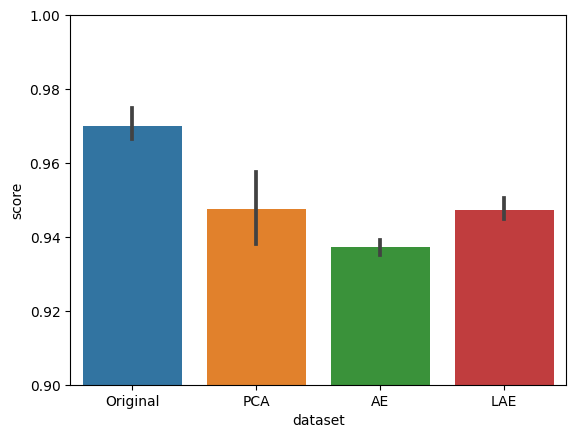

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rfc = RandomForestClassifier(n_estimators=200, max_depth=5)

labels = ['Original', 'PCA','AE']
scores = pd.DataFrame(columns=labels)
scores['PCA'] = cross_val_score(rfc, scores_train, y_tr, cv=5)
scores['AE'] = cross_val_score(rfc, codings_train, y_tr, cv=5)
scores['LAE'] = cross_val_score(rfc, nl_st_codings_train, y_tr, cv=5)
scores['Original'] = cross_val_score(rfc, X_tr_std, y_tr, cv=5)

sns.barplot(x='dataset', y='score', data = scores.melt(value_name='score', var_name='dataset'))
plt.ylim(0.9,1)